In [1]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'<<{_str}>>:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

# Model 설계 workfolw

In [2]:
!pip -q install lightning torchinfo  # Wall time: 1min 32s

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from torch import nn, torch_version
from torch.nn import functional as F
import torch.optim as optim

import lightning as L
from lightning.pytorch.accelerators import accelerator
import torchmetrics
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

torch.__version__,L.__version__,torchmetrics.__version__,torch_version.__version__

('2.6.0+cu124', '2.5.1.post0', '1.7.3', '2.6.0+cu124')

## 1. 첫번째 모델 만들기

## Dataset 준비  
#### num_workers  
##### MNIST는 memory에 모두 load되므로 file i/o 병목이 없음
##### 그럼에도 0,1 보다 4를 쓰면 속도 향상 있음(기본적인 전처리:ToTensor()등이 병렬처리 됨)

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def dataLoader(batch_size=128):
    train_dataset = MNIST('', transform=transforms.ToTensor(), train=True, download=True)
    test_dataset = MNIST('', transform=transforms.ToTensor(), train=False, download=True)
    trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return trainDataLoader,valDataLoader

trainDataLoader,valDataLoader = dataLoader(512)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.97MB/s]


##  Model 정의

### PyTorch Model

In [5]:
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10) )

    def forward(self, x):
        out = self.layers(x)
        return out

In [6]:
model = FirstModel()

#### Model 들여다 보기

In [7]:
print(model)

FirstModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [8]:
for name, parameter in model.named_parameters():
    print(f"Name:{name}\n  Parameter.shape:{parameter.shape}")

Name:layers.1.weight
  Parameter.shape:torch.Size([10, 784])
Name:layers.1.bias
  Parameter.shape:torch.Size([10])


#### Training

In [9]:
model = FirstModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    val_loss_epoch = []
    print(f'Epoch {epoch+1}\n-------------------------------')
    for train_batch in trainDataLoader:
        x, y = train_batch
        y_pred = model(x)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        val_loss = []
        for val_batch in valDataLoader:
            x, y = val_batch
            y_pred = model(x)
            val_loss.append(F.cross_entropy(y_pred, y).item())
        val_loss = np.mean(val_loss)
        val_loss_epoch.append(val_loss)
    print(f"loss: {loss:>7f}, val_loss: {val_loss:>7f}")

Epoch 1
-------------------------------
loss: 0.519418, val_loss: 0.615394
Epoch 2
-------------------------------
loss: 0.591942, val_loss: 0.450771
Epoch 3
-------------------------------
loss: 0.383281, val_loss: 0.389754
Epoch 4
-------------------------------
loss: 0.329710, val_loss: 0.356833
Epoch 5
-------------------------------
loss: 0.240435, val_loss: 0.336240
Epoch 6
-------------------------------
loss: 0.260687, val_loss: 0.323230
Epoch 7
-------------------------------
loss: 0.355054, val_loss: 0.312383
Epoch 8
-------------------------------
loss: 0.165629, val_loss: 0.304287
Epoch 9
-------------------------------
loss: 0.348465, val_loss: 0.298369
Epoch 10
-------------------------------
loss: 0.323504, val_loss: 0.294716


### PyTorch Lighting Model  

In [10]:
class Warp_10(L.LightningModule):
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        self.log_dict({'loss':loss, 'acc':acc})#,on_step=True, on_epoch=False)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        self.log_dict({'val_loss':loss, 'val_acc':acc})#,on_step=False, on_epoch=True)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [11]:
class FirstModel(Warp_10):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10) )

    def forward(self, x):
        out = self.layers(x)
        return out

In [12]:
model = FirstModel()
summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FirstModel                               [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [13]:
model

FirstModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

## Trainer 정의  
### Training, History logging

In [14]:
%%time
model = FirstModel()
epochs = 5

logger = L.pytorch.loggers.CSVLogger("logs", name="firstModel")
trainer = L.Trainer(max_epochs=epochs, logger=logger) #default: accelerator="auto"
trainer.fit(model, trainDataLoader, valDataLoader)
# Wall time: 17.9 s

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 7.9 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 5.6 s, sys: 1.71 s, total: 7.31 s
Wall time: 13.4 s


### torch.compile() API : 일반적으로 5%에서 30% 정도의 속도 향상을 기대   
#### model 크기, GPU 종류에 따라 다름(최신 GPU에서 효과적)  
#### input shape이 변할때 마다 다시 compile하므로, shape이 고정되어 있어야 효과적    
#### 현재 코드에서는 : Lightning logger호출시 shape이 달라져서 재컴파일이 발생하여 더 늦어지고 있음

In [15]:
%%time
model = FirstModel()
model = torch.compile(model) #######
epochs = 5
logger = L.pytorch.loggers.CSVLogger("logs", name="firstModel")
trainer = L.Trainer(max_epochs=epochs, logger=logger) #default: accelerator="auto"
trainer.fit(model, trainDataLoader, valDataLoader)
# Wall time: 40.7 s

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 7.9 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

W0616 07:40:17.222000 2742 torch/_inductor/utils.py:1137] [9/0_1] Not enough SMs to use max_autotune_gemm mode


Validation: |          | 0/? [00:00<?, ?it/s]

W0616 07:40:25.190000 2742 torch/_dynamo/convert_frame.py:906] [5/8] torch._dynamo hit config.cache_size_limit (8)
W0616 07:40:25.190000 2742 torch/_dynamo/convert_frame.py:906] [5/8]    function: 'log' (/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/module.py:376)
W0616 07:40:25.190000 2742 torch/_dynamo/convert_frame.py:906] [5/8]    last reason: 5/0: ___check_obj_id(L['self']._trainer._logger_connector._current_fx, 9695488)
W0616 07:40:25.190000 2742 torch/_dynamo/convert_frame.py:906] [5/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0616 07:40:25.190000 2742 torch/_dynamo/convert_frame.py:906] [5/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 17.7 s, sys: 3.4 s, total: 21.1 s
Wall time: 35.2 s


* Log data 보기

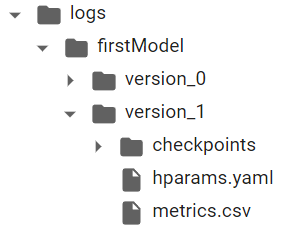

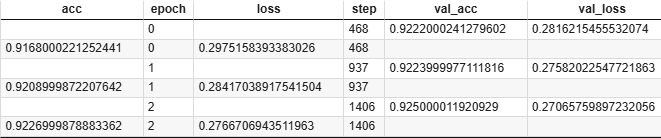

### Test

In [16]:
test_batch = next(iter(valDataLoader))            #(128,1,28,28),(128,) <-
preds = model(test_batch[0])                      #image만  #(128,10) <- (128,1,28,28)
p(preds[0],'preds'),print()                       # Class logits (10,)
p(torch.softmax(preds[0],dim=0),'softmax'),print()# Class Prob.  (10,)
p(np.argmax(torch.softmax(preds[0],dim=0).detach()),'index') # Class idx
p(np.argmax(preds[0].detach()),'index')           #  확률로 바꿀필요 없음

<<preds>>:
Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([-1.1913, -5.7702, -0.9512,  1.5488, -2.6735, -1.4432, -4.7773,  7.1729,
        -1.0603,  1.5315], grad_fn=<SelectBackward0>)

<<softmax>>:
Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([2.3117e-04, 2.3734e-06, 2.9391e-04, 3.5805e-03, 5.2509e-05, 1.7969e-04,
        6.4053e-06, 9.9187e-01, 2.6354e-04, 3.5193e-03],
       grad_fn=<SoftmaxBackward0>)

<<index>>:
Shape:torch.Size([])
Type: <class 'torch.Tensor'>
Values: 7
<<index>>:
Shape:torch.Size([])
Type: <class 'torch.Tensor'>
Values: 7


* History file read

In [34]:
v_num = logger.version
history = pd.read_csv(f'./logs/firstModel/version_{v_num}/metrics.csv')
#history
history.groupby('epoch').last().drop('step', axis=1)

,acc,loss,val_acc,val_loss
epoch,,,,
0,0.849609,0.698385,0.8676,0.615330
1,0.882812,0.485209,0.8943,0.448493
2,0.908203,0.401607,0.9024,0.387663
3,0.896484,0.379928,0.9079,0.353075
4,0.902344,0.353362,0.9105,0.332174


# 2. 모듈을 만드는 방법

## Module container 사용

In [18]:
class Model(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(5, 10)
        self.linear2 = nn.Linear(10,1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

model = Model()
summary(model, input_size=(8, 5))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1]                    --
├─Linear: 1-1                            [8, 10]                   60
├─Linear: 1-2                            [8, 1]                    11
Total params: 71
Trainable params: 71
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [19]:
model

Model(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)

**module class를 instance하여 module 구성하기**

In [20]:
class MyModel(L.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()

    def forward(self, x):
        out = self.layers(x)
        return out

model = MyModel()
summary(model, input_size=(8, 5))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 1]                    --
├─Model: 1-1                             [8, 1]                    --
│    └─Linear: 2-1                       [8, 10]                   60
│    └─Linear: 2-2                       [8, 1]                    11
Total params: 71
Trainable params: 71
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [21]:
p(model,'model');print()
p(model.layers,'model.layers');print()
p(model.layers.linear1,'model.layers.linear1');print()
p(model.layers.children,'model.layers.children')

<<model>>:
Type: <class '__main__.MyModel'>
Values: MyModel(
  (layers): Model(
    (linear1): Linear(in_features=5, out_features=10, bias=True)
    (linear2): Linear(in_features=10, out_features=1, bias=True)
  )
)

<<model.layers>>:
Type: <class '__main__.Model'>
Values: Model(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)

<<model.layers.linear1>>:
Type: <class 'torch.nn.modules.linear.Linear'>
Values: Linear(in_features=5, out_features=10, bias=True)

<<model.layers.children>>:
Type: <class 'method'>
Values: <bound method Module.children of Model(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)>


## Sequential container : Type 1

 - argument로 module을 전달



In [22]:
class Model(L.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers =  nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64,10)
            )
    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28*28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1, 10]                --
├─Sequential: 1-1                        [8, 1, 10]                --
│    └─Linear: 2-1                       [8, 1, 64]                50,240
│    └─ReLU: 2-2                         [8, 1, 64]                --
│    └─Linear: 2-3                       [8, 1, 10]                650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [23]:
model

Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

### Sequential + add_module(): Type 2

In [24]:
class Model(L.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential()
        self.layers.add_module('linear1', nn.Linear(28*28, 64))
        self.layers.add_module('linear2', nn.Linear(64,10))

    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28*28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1, 10]                --
├─Sequential: 1-1                        [8, 1, 10]                --
│    └─Linear: 2-1                       [8, 1, 64]                50,240
│    └─Linear: 2-2                       [8, 1, 10]                650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [25]:
model

Model(
  (layers): Sequential(
    (linear1): Linear(in_features=784, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=10, bias=True)
  )
)

### Sequential + OrderedDict : Type 3

In [26]:
from collections import OrderedDict
class Model(L.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten()),
            ('linear1', nn.Linear(28*28,64)),
            ('linear2', nn.Linear(64,10)),
          ]))
    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 64]                   50,240
│    └─Linear: 2-3                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [27]:
model

Model(
  (layers): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=784, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=10, bias=True)
  )
)

## ModuleList

In [28]:
class Model(L.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(5)])

    def forward(self, x):
        for l in self.linears:
            x = l(x)
        return x

model = Model()
summary(model, input_size=(8, 1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1, 10]                --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [8, 1, 10]                110
│    └─Linear: 2-2                       [8, 1, 10]                110
│    └─Linear: 2-3                       [8, 1, 10]                110
│    └─Linear: 2-4                       [8, 1, 10]                110
│    └─Linear: 2-5                       [8, 1, 10]                110
Total params: 550
Trainable params: 550
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [29]:
model

Model(
  (linears): ModuleList(
    (0-4): 5 x Linear(in_features=10, out_features=10, bias=True)
  )
)

In [30]:
class Model(L.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(5)])

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed using ints
        for i, l in enumerate(self.linears):
            x = self.linears[i // 2](x) + l(x)
        return x
    #0: x = l[0](x)+l[0](x)
    #1: x = l[0](x)+l[1](x)
    #2: x = l[1](x)+l[2](x)
    #3: x = l[1](x)+l[3](x)
    #4: x = l[2](x)+l[4](x)

model = Model()
summary(model, input_size=(8, 1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1, 10]                --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [8, 1, 10]                110
│    └─Linear: 2-2                       [8, 1, 10]                (recursive)
│    └─Linear: 2-3                       [8, 1, 10]                (recursive)
│    └─Linear: 2-4                       [8, 1, 10]                110
│    └─Linear: 2-5                       [8, 1, 10]                (recursive)
│    └─Linear: 2-6                       [8, 1, 10]                110
│    └─Linear: 2-7                       [8, 1, 10]                (recursive)
│    └─Linear: 2-8                       [8, 1, 10]                110
│    └─Linear: 2-9                       [8, 1, 10]                (recursive)
│    └─Linear: 2-10                      [8, 1, 10]                110
Total params: 550
Trainable params:

In [31]:
model

Model(
  (linears): ModuleList(
    (0-4): 5 x Linear(in_features=10, out_features=10, bias=True)
  )
)

## ModuleDict

In [32]:
class Model(L.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.choices = nn.ModuleDict({
                'conv': nn.Conv2d(10, 10, 3),
                'pool': nn.MaxPool2d(2)
        })
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU()],
                ['prelu', nn.PReLU()]
        ])

    def forward(self, x, choice, act):
        x = self.layers[choice](x)
        x = self.activations[act](x)
        return x

model = Model()

In [33]:
model

Model(
  (choices): ModuleDict(
    (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (activations): ModuleDict(
    (lrelu): LeakyReLU(negative_slope=0.01)
    (prelu): PReLU(num_parameters=1)
  )
)